In [30]:
import numpy as np
import sys
import csv
import re
import scipy.sparse as sp

# method = sys.argv[1]
# learning_rate = int(sys.argv[2])
# iterations = int(sys.argv[3])
# batch_size = int(sys.argv[4])
# training_data_path = sys.argv[5]
# vocabulary_path = sys.argv[6]
# testing_data_path = sys.argv[7]
# output_path = sys.argv[8]

lambdas = [0.1,1,10,100,1000]
folds = 10

method = 1
learning_rate = 0.001
iterations = 1000
batch_size = 128
training_data_path = '../data/imdb_train.csv'
vocabulary_path = '../data/imdb_vocab'
testing_data_path = '../data/imdb_test.csv'
output_path = 'out/imdb_output_a.txt'

In [31]:
def load(data_path,vocab_map,num_features):
    Y = []
    S = []
#     regex = re.compile('[^a-zA-Z ]')
    with open(data_path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamreader = list(spamreader)
        n = len(spamreader)
        S = sp.dok_matrix((n,num_features), dtype=np.int64)
        #X = np.zeros((n,num_features))
        Y = np.zeros((n,1))
        i = 0
        for row in spamreader:
#             cleaned_text = regex.sub('',row[1])
            words = row[1].split(' ')
            S[i,0] = 1
            for word in words:
                if word in vocab_map:
                    S[i,vocab_map[word]] += 1
            Y[i] = int(row[0])
            i += 1
    return S.tocsr(),Y

def load_data(data_path,vocab_map,num_features):
    X_sparse,Y = load(data_path,vocab_map,num_features)
    return X_sparse,Y

def load_vocab(data_path):
    vocab_map = {}
    with open(data_path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')        
        i = 0
        for row in spamreader:
            if row[0] not in vocab_map:
                vocab_map[row[0]] = i + 1
                i += 1
    return vocab_map, i+1

def sigmoid(t):
    return 1.0 / (1.0 + np.exp(t * -1))

def get_log_likelihood(W,X,Y):
    X_W = X.dot(W)
    Predictions = sigmoid(X_W)
    return np.sum(Y.T.dot(np.log(Predictions)) + (1-Y.T).dot(np.log(1-Predictions)))/Y.shape[0]

def get_predictions(W,X):
    X_W = X.dot(W)
    return np.rint(sigmoid(X_W))

def get_accuracy(W,X,Y):
    Predictions = get_predictions(W,X)
    return 100*np.sum(Predictions == Y)/Y.shape[0]

def f_dash_gamma(X_W,Xd,Y,gamma):
    return (sigmoid(X_W + Xd.dot(gamma)) - Y).T.dot(Xd)

def get_optimal_learning_rate(W,X,Y):
    X_W = X.dot(W)
    d = X.T.dot(Y - sigmoid(X_W))
    d = d / np.linalg.norm(d)
    Xd = X.dot(d)
    
    gamma1 = 0.0
    gamma2 = 1.0
#     print(np.absolute(gamma1-gamma2) > 0.001)
    while(np.absolute(gamma1-gamma2) > 0.001):
        mid = (gamma1 + gamma2)/2
        f_dash_val = f_dash_gamma(X_W,Xd,Y,mid)
#         print(gamma1,gamma2,f_dash_val)
        if (f_dash_val < 0):
            gamma1 = mid
        else:
            gamma2 = mid
    print(gamma1)
    return (gamma1 + gamma2) / 2

def train_model(inpX,inpY,iterations,learning_rate,lam,batch_size,learning_rate_mode):
    m = inpX.shape[1]
    n= inpX.shape[0]
    num_iters_max = int(0.5 + n/batch_size)
    W = np.zeros((m,1))
#     XT = X.transpose()
    for i in range(iterations):
        
        i_eff = i%num_iters_max
        if i_eff != num_iters_max - 1:
            X = inpX[i_eff*batch_size: (i_eff+1)*batch_size]
            Y = inpY[i_eff*batch_size: (i_eff+1)*batch_size]
        else:
            X = inpX[i_eff*batch_size:]
            Y = inpY[i_eff*batch_size:]
        XT = X.transpose()
        
        g_val = sigmoid(X.dot(W))
        logLike.append(get_log_likelihood(W,X,Y))
#         print('Accuracy = ',get_accuracy(W,X,Y))
#         print('Log Likeli = ',get_log_likelihood(W,X,Y))
        if (learning_rate_mode == 1):
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(learning_rate).dot(1/X.shape[0])
        elif (learning_rate_mode == 2):
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(learning_rate / np.sqrt(i+1)).dot(1/X.shape[0])
        else:
            lr = get_optimal_learning_rate(W,X,Y)
#             print('Best Learning Rate ..= ',lr)
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(lr).dot(1/X.shape[0])
    return W

def kFold_cross_validation(X,Y,lambdas,folds,iterations,learning_rate,batch_size,learning_rate_mode):
    
    fold_size = int(X.shape[0]/folds)
    
    sums = []
    for lam in lambdas:
        sums.append(0.0)
        
    for i in range(folds):
        if i < folds - 1 :
            X_test = X[i*fold_size:(i+1)*fold_size]
            X_train = sp.vstack((X[:i*fold_size],X[(i+1)*fold_size:]))
            Y_test = Y[i*fold_size:(i+1)*fold_size]
            Y_train = np.vstack((Y[:i*fold_size],Y[(i+1)*fold_size:]))
        else:
            X_test = X[i*fold_size:]
            X_train = X[:i*fold_size]
            Y_test = Y[i*fold_size:]
            Y_train = Y[:i*fold_size]
        for i in range(len(lambdas)):
            W= train_model(X_train,Y_train,iterations,learning_rate,lambdas[i],batch_size,learning_rate_mode)
#             sums[i] += get_log_likelihood(W,X_test,Y_test)
            sums[i] += get_accuracy(W,X_test,Y_test)
        print(sums)
    for i in range(0,len(sums)):
        sums[i] /= folds
    return sums

In [32]:
vocab_map, m = load_vocab(vocabulary_path)

In [33]:
# print(vocab_map)
# print(m)

In [34]:
X,Y = load_data(training_data_path,vocab_map,m)

In [35]:
#print(X_train_sparse)
#print(Y_train)

In [36]:
# print(X.shape)

In [37]:
# print(Y.shape)

In [38]:
# W = train_model(X,Y,iterations,learning_rate,0.01,2)


In [39]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,128,1)
print(logLike)

[-0.6931471805599453, -0.6921468861347966, -0.6936669515834433, -0.6926781628076867, -0.6923139910093352, -0.6928320691462823, -0.6922989820260845, -0.6924078000155027, -0.6910089908561546, -0.6907000859829339, -0.6910955307472886, -0.69618734399608, -0.6905762103302636, -0.6907121131546312, -0.6918933896865208, -0.6906125432035749, -0.6898120174023632, -0.6873891491956674, -0.682483944953244, -0.6876237836732633, -0.6825892646048711, -0.6895717277628659, -0.691064974163764, -0.693797060050792, -0.6837617288000472, -0.689741818424105, -0.6891675748168217, -0.6885414843482465, -0.6876389073139382, -0.6936826134565748, -0.6891725699027016, -0.6904065551399494, -0.6871117538820857, -0.6887599358808749, -0.683062261772174, -0.6877249860839076, -0.6849214612002525, -0.68684244759601, -0.6862820876592624, -0.6811219560625732, -0.6816932230428399, -0.6854731565530294, -0.685658243883551, -0.6848429154959006, -0.6849843273865115, -0.6780421130916828, -0.681340395699672, -0.6845079196972046, -0

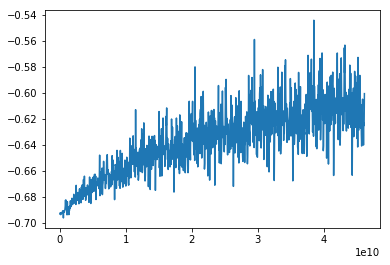

In [40]:
import matplotlib.pyplot as plt
import numpy as np

x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*46196960)

plt.plot(x_values,logLike)
plt.show()

In [41]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,128,2)
print(logLike)

[-0.6931471805599453, -0.6921468861347966, -0.6935914670089566, -0.6928674430533531, -0.6927195867983397, -0.6936190004921468, -0.6916997578354338, -0.6931485009377418, -0.692320745860508, -0.6917070878459641, -0.6933788971717921, -0.6927673315300037, -0.6919787957225413, -0.6916303729050455, -0.6927004610689781, -0.6923767012109399, -0.6923018029580397, -0.6914496059655348, -0.6901370601937011, -0.6910859862546848, -0.6896082406296218, -0.6915278431467972, -0.6919631962643644, -0.6926044620047189, -0.689280388640114, -0.6914846167125582, -0.6916955871859327, -0.6914555537202947, -0.6911776776309465, -0.6945362645875661, -0.6909048177897781, -0.6931905247205858, -0.692899183995968, -0.6917872286304337, -0.6899217521075597, -0.6892066897691493, -0.690041926273635, -0.6914645110662985, -0.6903825964790182, -0.6889099044196394, -0.6890282072561498, -0.6915519127422274, -0.6922649275059178, -0.6881103797613992, -0.6918640271723299, -0.6877561885976455, -0.6887509273474139, -0.6913735196197

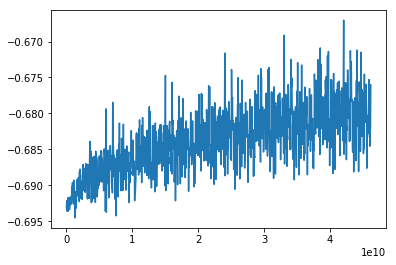

In [42]:
x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*46196961)

plt.plot(x_values,logLike)
plt.show()

In [43]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,128,3)
print(logLike)

0.015625
0.0185546875
0.69921875
0.052734375
0.17578125
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.794921875
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234

/home/ankurshaswat/MyFiles/Repos/COL341/env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/home/ankurshaswat/MyFiles/Repos/COL341/env/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.697265625
0.9736328125
0.802734375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.6826171875
0.9990234375
0.9990234375
0.9990234375
0.26953125
0.615234375
0.9990234375
0.9111328125
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.99

0.4755859375
0.9990234375
0.41015625
0.9990234375
0.87109375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.611328125
0.9990234375
0.876953125
0.9990234375
0.80859375
0.6669921875
0.9990234375
0.5849609375
0.9990234375
0.54296875
0.9990234375
0.958984375
0.7705078125
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.6865234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.9990234375
0.99902343

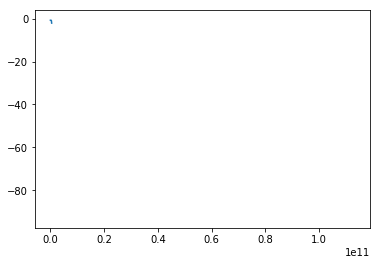

In [44]:
x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*115145434)

plt.plot(x_values,logLike)
plt.show()

In [25]:
# W = train_model(X,Y,iterations,learning_rate,0.01)

# W = train_model(X,Y,iterations,learning_rate,0.01,1)
accuracy = kFold_cross_validation(X,Y,lambdas,folds,iterations,learning_rate,batch_size,method)

[73.2, 70.08, 53.16, 50.8, 50.8]
[154.32, 148.07999999999998, 105.8, 101.03999999999999, 100.6]
[237.88, 228.35999999999999, 159.32, 151.35999999999999, 150.35999999999999]
[313.88, 306.52, 211.56, 200.79999999999998, 201.04]
[395.28, 385.96, 264.16, 251.48, 251.68]
[469.52, 453.79999999999995, 317.48, 301.8, 301.88]
[542.8, 521.64, 370.56, 351.40000000000003, 351.52]
[615.52, 590.84, 436.36, 402.04, 402.2]
[689.4, 663.1600000000001, 503.20000000000005, 449.72, 449.91999999999996]
[762.72, 733.6800000000001, 568.36, 501.40000000000003, 501.59999999999997]


In [26]:
max = accuracy[0]
lam = lambdas[0]

for i in range (0,len(lambdas)):
    if (accuracy[i] > max):
        lam = lambdas[i]
        max = accuracy[i]
        
print(lam)

0.1


In [33]:
W = train_model(X,Y,iterations,learning_rate,lam,batch_size,method)

Accuracy =  55.46875
Accuracy =  57.03125
Accuracy =  54.6875
Accuracy =  54.6875
Accuracy =  51.5625
Accuracy =  41.40625
Accuracy =  45.3125
Accuracy =  52.34375
Accuracy =  48.4375
Accuracy =  51.5625
Accuracy =  53.90625
Accuracy =  60.9375
Accuracy =  46.09375
Accuracy =  57.03125
Accuracy =  50.0
Accuracy =  51.5625
Accuracy =  50.78125
Accuracy =  57.03125
Accuracy =  59.375
Accuracy =  46.875
Accuracy =  55.46875
Accuracy =  56.25
Accuracy =  51.5625
Accuracy =  50.78125
Accuracy =  51.5625
Accuracy =  51.5625
Accuracy =  48.4375
Accuracy =  59.375
Accuracy =  53.90625
Accuracy =  63.28125
Accuracy =  57.03125
Accuracy =  53.125
Accuracy =  53.90625
Accuracy =  50.78125
Accuracy =  54.6875
Accuracy =  43.75
Accuracy =  51.5625
Accuracy =  55.46875
Accuracy =  56.25
Accuracy =  63.28125
Accuracy =  54.6875
Accuracy =  56.25
Accuracy =  58.59375
Accuracy =  37.5
Accuracy =  42.96875
Accuracy =  45.3125
Accuracy =  55.46875
Accuracy =  68.75
Accuracy =  53.90625
Accuracy =  55.468

Accuracy =  69.53125
Accuracy =  63.28125
Accuracy =  49.21875
Accuracy =  57.03125
Accuracy =  60.15625
Accuracy =  63.28125
Accuracy =  57.03125
Accuracy =  60.15625
Accuracy =  67.96875
Accuracy =  55.46875
Accuracy =  57.03125
Accuracy =  64.0625
Accuracy =  66.40625
Accuracy =  65.625
Accuracy =  78.90625
Accuracy =  82.8125
Accuracy =  84.375
Accuracy =  82.8125
Accuracy =  77.34375
Accuracy =  76.5625
Accuracy =  69.53125
Accuracy =  65.625
Accuracy =  64.84375
Accuracy =  58.59375
Accuracy =  63.28125
Accuracy =  71.09375
Accuracy =  69.53125
Accuracy =  55.46875
Accuracy =  60.9375
Accuracy =  78.90625
Accuracy =  60.15625
Accuracy =  56.25
Accuracy =  61.71875
Accuracy =  73.4375
Accuracy =  64.0625
Accuracy =  64.0625
Accuracy =  60.15625
Accuracy =  72.65625
Accuracy =  75.78125
Accuracy =  75.0
Accuracy =  80.46875
Accuracy =  73.4375
Accuracy =  78.125
Accuracy =  78.125
Accuracy =  75.78125
Accuracy =  72.65625
Accuracy =  62.5
Accuracy =  72.65625
Accuracy =  71.875
Acc

Accuracy =  75.78125
Accuracy =  75.78125
Accuracy =  79.6875
Accuracy =  84.375
Accuracy =  78.125
Accuracy =  78.125
Accuracy =  75.78125
Accuracy =  79.6875
Accuracy =  80.46875
Accuracy =  72.65625
Accuracy =  67.1875
Accuracy =  78.90625
Accuracy =  83.59375
Accuracy =  91.40625
Accuracy =  82.03125
Accuracy =  80.46875
Accuracy =  79.6875
Accuracy =  71.875
Accuracy =  73.4375
Accuracy =  73.4375
Accuracy =  72.65625
Accuracy =  76.5625
Accuracy =  74.21875
Accuracy =  78.125
Accuracy =  85.9375
Accuracy =  82.8125
Accuracy =  82.8125
Accuracy =  82.03125
Accuracy =  81.25
Accuracy =  84.375
Accuracy =  75.0
Accuracy =  77.34375
Accuracy =  78.90625
Accuracy =  75.78125
Accuracy =  76.5625
Accuracy =  72.65625
Accuracy =  73.4375
Accuracy =  69.53125
Accuracy =  69.53125
Accuracy =  74.21875
Accuracy =  58.59375
Accuracy =  50.78125
Accuracy =  72.65625
Accuracy =  75.78125
Accuracy =  69.53125
Accuracy =  64.0625
Accuracy =  78.125
Accuracy =  77.34375
Accuracy =  74.21875
Accur

In [17]:
X_test,Y_test = load_data(testing_data_path,vocab_map,m)

In [28]:
print(get_accuracy(W,X_test,Y_test))

73.74


In [19]:
# print(X_test.shape)

In [29]:
Predictions = get_predictions(W,X_test)
np.savetxt(output_path,Predictions)